In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [12]:
import numpy as np
import torch

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect

def cent_plot(ax,x,y,c='k',ls='-'):
    n = len(x)
    if n % 2 == 0:
        xroll = np.roll(x,n//2-1)
        xroll[xroll > 90] -= 180
        xroll = np.append(-xroll[-1],xroll)
        yroll = np.roll(y,n//2-1)
        yroll = np.append(yroll[-1],yroll)
    else:
        xroll = np.roll(x,n//2)
        xroll[xroll > 90] -= 180
        yroll = np.roll(y,n//2)
    ax.plot(xroll,yroll,c=c,ls=ls)
    ax.set_xlim(-90,90)
    
def cent_bar_plot(ax,x,ymean,yerr,c='k',ls='-'):
    n = len(x)
    if n % 2 == 0:
        xroll = np.roll(x,n//2-1)
        xroll[xroll > 90] -= 180
        xroll = np.append(-xroll[-1],xroll)
        ymeanroll = np.roll(ymean,n//2-1)
        ymeanroll = np.append(ymeanroll[-1],ymeanroll)
        yerrroll = np.roll(yerr,n//2-1)
        yerrroll = np.append(yerrroll[-1],yerrroll)
    else:
        xroll = np.roll(x,n//2)
        xroll[xroll > 90] -= 180
        ymeanroll = np.roll(ymean,n//2)
        yerrroll = np.roll(yerr,n//2)
    ax.plot(xroll,ymeanroll,c=c,ls=ls)
    ax.fill_between(xroll,ymeanroll+yerrroll,ymeanroll-yerrroll,color=c,ls=ls,alpha=0.5)
    ax.set_xlim(-90,90)
    
def imshowbar(ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imsh, cax=cax, orientation='vertical')

# Test Ricciardi Interpolation with Tensors

In [4]:
import ricciardi as ric

In [5]:
reload(ric)
ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')

Loading previously saved nonlinearity


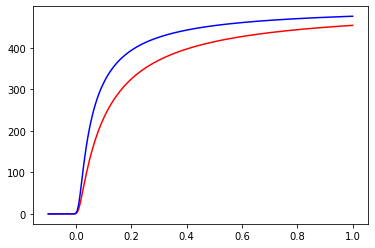

In [48]:
plt.plot(torch.linspace(-0.1,1.0,201),ri.phiE(torch.linspace(-0.1,1.0,201)),'r')
plt.plot(torch.linspace(-0.1,1.0,201),ri.phiI(torch.linspace(-0.1,1.0,201)),'b')

# Test Building Networks with Tensors

In [10]:
import ring_network as network

2023-05-04 11:47:06.408375: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# W = np.array(
#     [[ 0.006, -0.0055],
#      [ 0.002, -0.0015]])
# varW = np.abs(W)*2e-5

# H = np.array(
#     [0.04, 0.01])
# varH = H*2e-5

W = np.array(
    [[ 0.0059935,  -0.00558789],
     [ 0.00191934, -0.00148332]])

varW = np.array(
    [[1.44631490e-07, 4.05076461e-07],
     [1.48817309e-08, 2.61660262e-08]])
varW *= 0.25

H = np.array(
    [0.03546839, 0.00570064])

varH = np.array(
    [6.88476238e-05, 1.77849733e-06])

In [14]:
# sW = 30*np.ones((2,2))
# svarW = sW/np.sqrt(2)

# sH = 20*np.ones(2)
# svarH = sH/np.sqrt(2)

sW = np.array(
    [[30.83396677, 28.0905561 ],
     [30.81846077, 28.12876527]])

svarW = np.array(
    [[51.13752838, 60.32264355],
     [52.26360741, 55.5939705 ]])
svarW = sW/np.sqrt(2)

sH = np.array(
    [18.73568193, 18.73568205])

svarH = np.array(
    [8.70076152, 8.70075169])
svarH = sH/np.sqrt(2)

In [15]:
Lam = 1e-3
CV_Lam = 12.168145
L = 5.068195

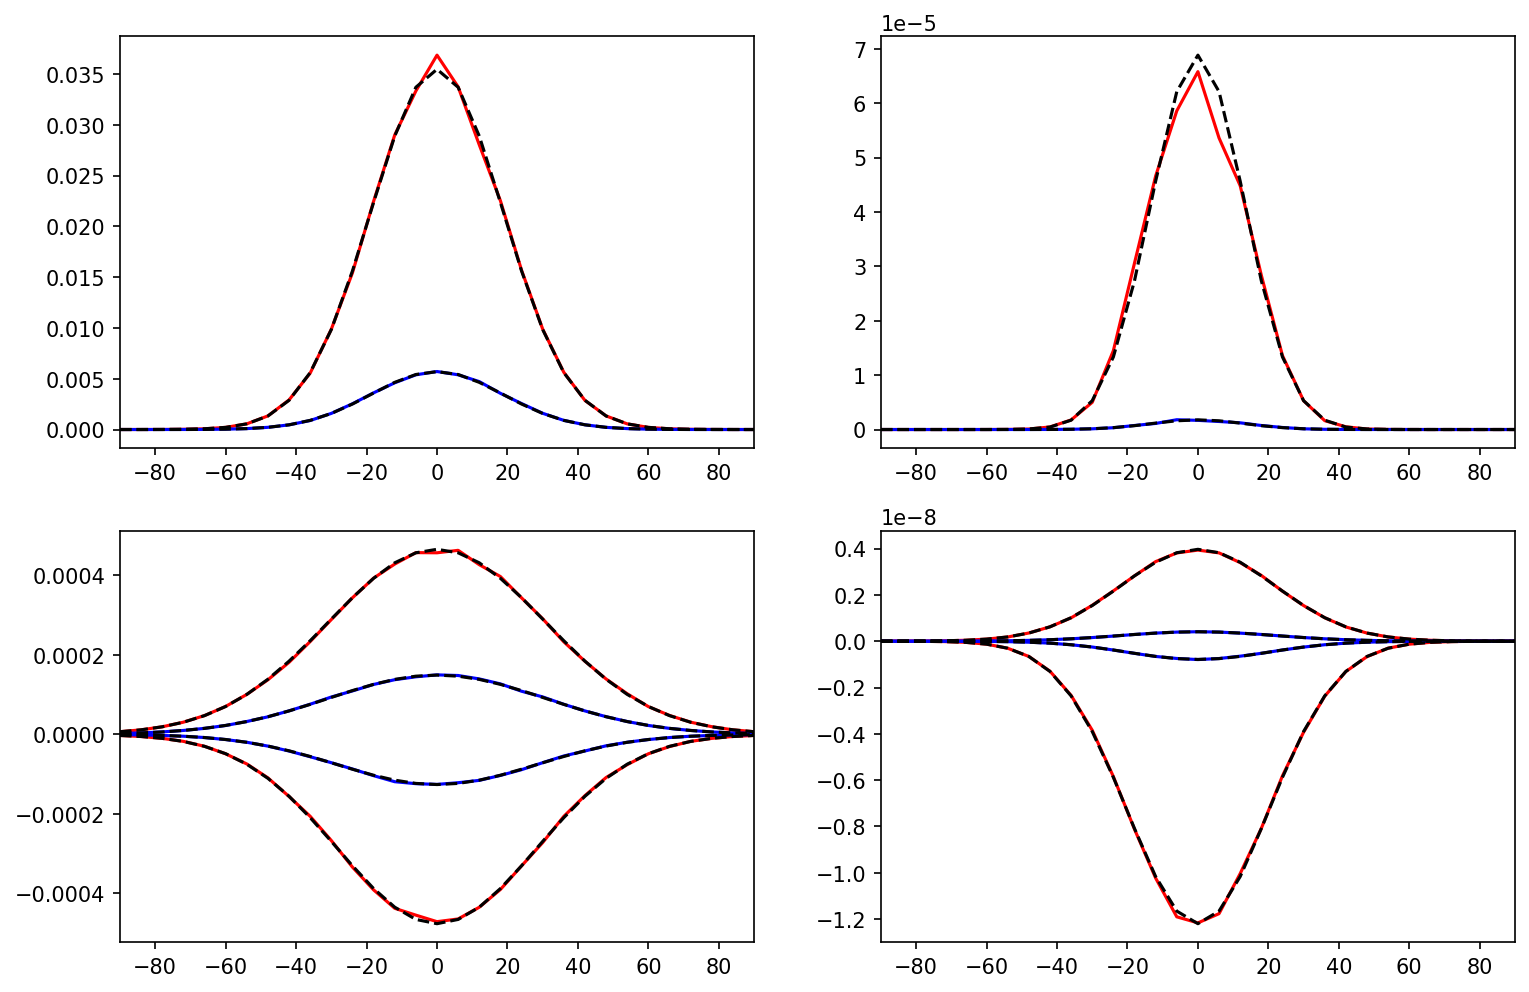

In [69]:
reload(network)

net = network.network(Nl=30,NE=100,SW=sW,SvarW=svarW,SH=sH,SvarH=svarH)

net_H_E_mean = np.zeros(net.Nl)
net_H_I_mean = np.zeros(net.Nl)
net_H_E_var = np.zeros(net.Nl)
net_H_I_var = np.zeros(net.Nl)
net_M_EE_mean = np.zeros(net.Nl)
net_M_EI_mean = np.zeros(net.Nl)
net_M_IE_mean = np.zeros(net.Nl)
net_M_II_mean = np.zeros(net.Nl)
net_M_EE_var = np.zeros(net.Nl)
net_M_EI_var = np.zeros(net.Nl)
net_M_IE_var = np.zeros(net.Nl)
net_M_II_var = np.zeros(net.Nl)

seeds = np.arange(4)
for seed in seeds:
    net.set_seed(seed)
    net.generate_disorder(W,varW,H,varH,Lam,CV_Lam)
#     net.M[:,net.E_all] = np.maximum(0,net.M[:,net.E_all])
#     net.M[:,net.I_all] = np.minimum(0,net.M[:,net.I_all])
    
    net_H_E_mean += np.mean(net.H[net.E_all].reshape((-1,net.NE)),axis=1)
    net_H_I_mean += np.mean(net.H[net.I_all].reshape((-1,net.NI)),axis=1)
    net_H_E_var += np.var(net.H[net.E_all].reshape((-1,net.NE)),axis=1)
    net_H_I_var += np.var(net.H[net.I_all].reshape((-1,net.NI)),axis=1)
    
    net_M_EE_mean += np.mean(net.M[net.E_all][:,net.E_all].reshape((-1,net.NE,net.Nl,net.NE))[0],axis=(0,2))
    net_M_EI_mean += np.mean(net.M[net.E_all][:,net.I_all].reshape((-1,net.NE,net.Nl,net.NI))[0],axis=(0,2))
    net_M_IE_mean += np.mean(net.M[net.I_all][:,net.E_all].reshape((-1,net.NI,net.Nl,net.NE))[0],axis=(0,2))
    net_M_II_mean += np.mean(net.M[net.I_all][:,net.I_all].reshape((-1,net.NI,net.Nl,net.NI))[0],axis=(0,2))
    net_M_EE_var += np.var(net.M[net.E_all][:,net.E_all].reshape((-1,net.NE,net.Nl,net.NE))[0],axis=(0,2))
    net_M_EI_var += np.var(net.M[net.E_all][:,net.I_all].reshape((-1,net.NE,net.Nl,net.NI))[0],axis=(0,2))
    net_M_IE_var += np.var(net.M[net.I_all][:,net.E_all].reshape((-1,net.NI,net.Nl,net.NE))[0],axis=(0,2))
    net_M_II_var += np.var(net.M[net.I_all][:,net.I_all].reshape((-1,net.NI,net.Nl,net.NI))[0],axis=(0,2))
    
net_H_E_mean /= len(seeds)
net_H_I_mean /= len(seeds)
net_H_E_var /= len(seeds)
net_H_I_var /= len(seeds)
net_M_EE_mean /= len(seeds)
net_M_EI_mean /= len(seeds)
net_M_IE_mean /= len(seeds)
net_M_II_mean /= len(seeds)
net_M_EE_var /= len(seeds)
net_M_EI_var /= len(seeds)
net_M_IE_var /= len(seeds)
net_M_II_var /= len(seeds)

fig,axs = plt.subplots(2,2,figsize=(12,8),dpi=150)

cent_plot(axs[0,0],net.ori_map[:,0],net_H_E_mean,'r')
cent_plot(axs[0,0],net.ori_map[:,0],net_H_I_mean,'b')
cent_plot(axs[0,0],net.ori_map[:,0],H[0]*net.make_vector(sH[0]),'k','--')
cent_plot(axs[0,0],net.ori_map[:,0],H[1]*net.make_vector(sH[1]),'k','--')

cent_plot(axs[0,1],net.ori_map[:,0],net_H_E_var,'r')
cent_plot(axs[0,1],net.ori_map[:,0],net_H_I_var,'b')
cent_plot(axs[0,1],net.ori_map[:,0],varH[0]*net.make_vector(svarH[0]),'k','--')
cent_plot(axs[0,1],net.ori_map[:,0],varH[1]*net.make_vector(svarH[1]),'k','--')

cent_plot(axs[1,0],net.ori_map[:,0],net.NE*net_M_EE_mean,'r')
cent_plot(axs[1,0],net.ori_map[:,0],net.NI*net_M_EI_mean,'r')
cent_plot(axs[1,0],net.ori_map[:,0],net.NE*net_M_IE_mean,'b')
cent_plot(axs[1,0],net.ori_map[:,0],net.NI*net_M_II_mean,'b')
cent_plot(axs[1,0],net.ori_map[:,0],W[0,0]*net.make_kernel(sW[0,0])[0],'k','--')
cent_plot(axs[1,0],net.ori_map[:,0],W[0,1]*net.make_kernel(sW[0,1])[0],'k','--')
cent_plot(axs[1,0],net.ori_map[:,0],W[1,0]*net.make_kernel(sW[1,0])[0],'k','--')
cent_plot(axs[1,0],net.ori_map[:,0],W[1,1]*net.make_kernel(sW[1,1])[0],'k','--')

cent_plot(axs[1,1],net.ori_map[:,0],net.NE*net_M_EE_var,'r')
cent_plot(axs[1,1],net.ori_map[:,0],-net.NI*net_M_EI_var,'r')
cent_plot(axs[1,1],net.ori_map[:,0],net.NE*net_M_IE_var,'b')
cent_plot(axs[1,1],net.ori_map[:,0],-net.NI*net_M_II_var,'b')
cent_plot(axs[1,1],net.ori_map[:,0],varW[0,0]*net.make_kernel(svarW[0,0])[0],'k','--')
cent_plot(axs[1,1],net.ori_map[:,0],-varW[0,1]*net.make_kernel(svarW[0,1])[0],'k','--')
cent_plot(axs[1,1],net.ori_map[:,0],varW[1,0]*net.make_kernel(svarW[1,0])[0],'k','--')
cent_plot(axs[1,1],net.ori_map[:,0],-varW[1,1]*net.make_kernel(svarW[1,1])[0],'k','--')

In [25]:
import integrate as integ

In [70]:
reload(integ)

net.generate_tensors()

NtE = 100
T = torch.linspace(0,NtE*ri.tE,round(NtE*ri.tE/(ri.tI/3))+1)
mask_time = T>(NtE/2*ri.tE)

sol = integ.sim_dyn(ri,T,0,net.M_torch,net.H_torch,net.LAM_torch,net.E_cond,mult_tau=False)

Using cpu


In [77]:
torch.mean(sol[mask_time],axis=0).numpy()

array([2.20946585e-02, 9.36137839e-01, 1.98508096e+02, ...,
       4.21617461e+01, 1.04228920e+02, 3.62178132e+01])

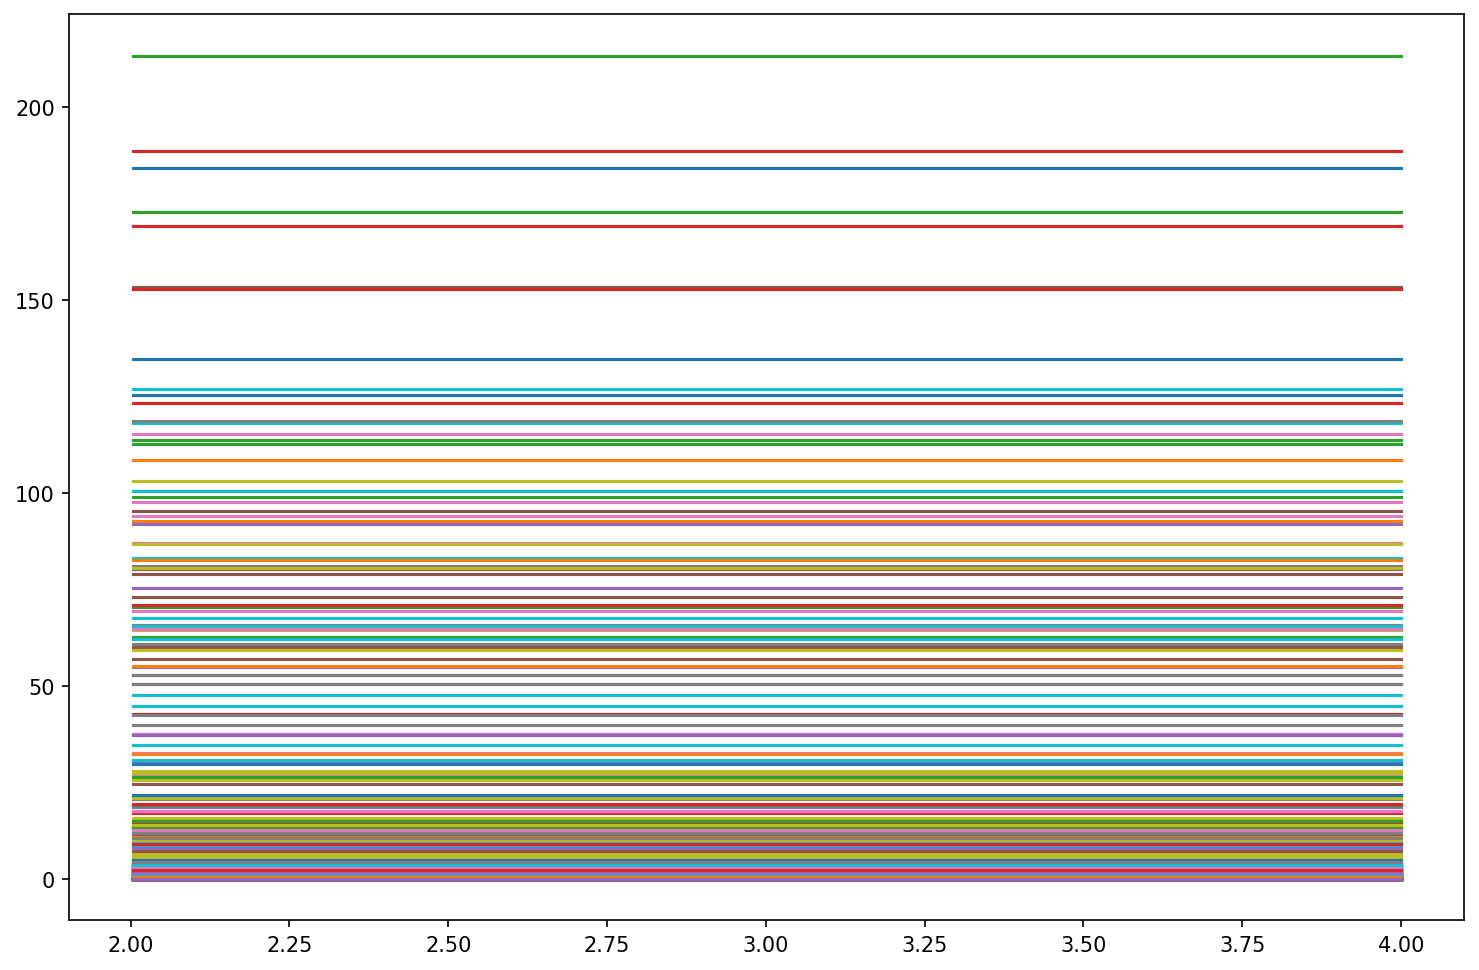

In [64]:
fig,ax = plt.subplots(1,1,figsize=(12,8),dpi=150)

ax.plot(T[mask_time],sol[mask_time][:,::20])

plt.show()

In [204]:
import inspect

def sim_ring(params_dict,ri,T,mask_time,seeds,max_min=15):
    this_params_dict = params_dict.copy()
    this_params_dict['seed_con'] = 0
    filtered_mydict_net = {k: v for k, v in this_params_dict.items() if k in [p.name for p in
                                                    inspect.signature(network.network).parameters.values()]}
    net = network.network(**filtered_mydict_net)
    rates = np.zeros((len(seeds),2,net.N))
    
    for seed_idx,seed in enumerate(seeds):
        print('Doing seed '+str(seed_idx+1) +' of '+str(len(seeds)))
        
        net.set_seed(int(seed))
        
        filtered_mydict_disorder = {k: v for k, v in this_params_dict.items() if k in [p.name for p in
                                            inspect.signature(net.generate_disorder).parameters.values()]}
        net.generate_disorder(**filtered_mydict_disorder)
        
        sol = integ.sim_dyn(ri,T,0.0,net.M_tf,net.H_tf,net.LAM_tf,net.E_cond,mult_tau=False)
        rates[seed_idx,0,:]=np.mean(sol[mask_time],axis=0)
        
        res = integ.sim_dyn(ri,T,params_dict['L'],net.M_tf,net.H_tf,net.LAM_tf,net.E_cond,mult_tau=False)
        rates[seed_idx,1,:]=np.mean(sol[mask_time],axis=0)
        
    return net,np.hstack([rates[i,:,:] for i in np.arange(len(seeds))])

In [205]:
reload(network)

params_dict = {}
params_dict['Nl'] = 12
params_dict['NE'] = 250
params_dict['W'] = W
params_dict['varW'] = varW
params_dict['SW'] = sW
params_dict['SvarW'] = svarW
params_dict['H'] = H
params_dict['varH'] = varH
params_dict['SH'] = sH
params_dict['SvarH'] = svarH
params_dict['Lam'] = Lam
params_dict['CV_Lam'] = CV_Lam
params_dict['L'] = L

NtE = 200
T = np.linspace(0,NtE*ri.tE,round(NtE*ri.tE/(ri.tI/3))+1)
mask_time = T>(NtE/2*ri.tE)
seeds = np.arange(16)

net,rates = sim_ring(params_dict,ri,T,mask_time,seeds)

oris = net.make_periodic(np.concatenate([net.Z for i in range(len(seeds))]),90)

Doing seed 1 of 16
Doing seed 2 of 16
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.9/site-packages/tensorflow_probability/python/math/ode/dormand_prince.py", line 696, in _write_solution_components
    return updated_arrays  File "/usr/local/lib/python3.9/site-packages/tensorflow/python/util/nest.py", line 916, in map_structure
    return pack_sequence_as(  File "/usr/local/lib/python3.9/site-packages/tensorflow/python/util/nest.py", line 917, in <listcomp>
    structure[0], [func(*x) for x in entries],  File "/usr/local/lib/python3.9/site-packages/tensorflow_probability/python/math/ode/dormand_prince.py", line 693, in <lambda>
    write_solution = lambda array, tensor: array.write(time_id, tensor)  File "/usr/local/lib/python3.9/site-packages/tensorflow/python/util/

In [207]:
H_base_input=np.zeros((len(seeds),net.N))
H_opto_input=np.zeros((len(seeds),net.N))
H_diff_input=np.zeros((len(seeds),net.N))

E_base_input=np.zeros((len(seeds),net.N))
E_opto_input=np.zeros((len(seeds),net.N))
E_diff_input=np.zeros((len(seeds),net.N))

I_base_input=np.zeros((len(seeds),net.N))
I_opto_input=np.zeros((len(seeds),net.N))
I_diff_input=np.zeros((len(seeds),net.N))

for seed_idx,seed in enumerate(seeds):
    net.set_seed(seed)
    filtered_mydict_disorder = {k: v for k, v in params_dict.items() if k in [p.name for p in
                                        inspect.signature(net.generate_disorder).parameters.values()]}
    net.generate_disorder(**filtered_mydict_disorder)
    
    this_rates = rates[:,seed_idx*net.N:(seed_idx+1)*net.N]
    
    MRbE = np.matmul(net.M[:,net.E_all],rates[0,net.E_all])
    MRbI = np.matmul(net.M[:,net.I_all],rates[0,net.I_all])
    MRoE = np.matmul(net.M[:,net.E_all],rates[1,net.E_all])
    MRoI = np.matmul(net.M[:,net.I_all],rates[1,net.I_all])
    
    H_base_input[seed_idx] = net.H
    H_opto_input[seed_idx] = net.H+L*net.LAM
    H_diff_input[seed_idx] = L*net.LAM
    
    E_base_input[seed_idx] = MRbE
    E_opto_input[seed_idx] = MRoE
    E_diff_input[seed_idx] = MRoE-MRbE
    
    I_base_input[seed_idx] = MRbI
    I_opto_input[seed_idx] = MRoI
    I_diff_input[seed_idx] = MRoI-MRbI

In [208]:
rate_nob = net.Nl//2
rate_ori_bounds=np.linspace(0,90,rate_nob+1)
rate_ori_centers = 0.5*(rate_ori_bounds[1:]+rate_ori_bounds[:-1])
rate_diff_width = (rate_ori_bounds[1]-rate_ori_bounds[0])/2

EF_base_input_per_ori_mean=np.zeros((rate_nob+1))
IF_base_input_per_ori_mean=np.zeros((rate_nob+1))
EF_base_input_per_ori_std=np.zeros((rate_nob+1))
IF_base_input_per_ori_std=np.zeros((rate_nob+1))

EE_base_input_per_ori_mean=np.zeros((rate_nob+1))
IE_base_input_per_ori_mean=np.zeros((rate_nob+1))
EE_base_input_per_ori_std=np.zeros((rate_nob+1))
IE_base_input_per_ori_std=np.zeros((rate_nob+1))

EI_base_input_per_ori_mean=np.zeros((rate_nob+1))
II_base_input_per_ori_mean=np.zeros((rate_nob+1))
EI_base_input_per_ori_std=np.zeros((rate_nob+1))
II_base_input_per_ori_std=np.zeros((rate_nob+1))

ET_base_input_per_ori_mean=np.zeros((rate_nob+1))
IT_base_input_per_ori_mean=np.zeros((rate_nob+1))
ET_base_input_per_ori_std=np.zeros((rate_nob+1))
IT_base_input_per_ori_std=np.zeros((rate_nob+1))

EF_opto_input_per_ori_mean=np.zeros((rate_nob+1))
IF_opto_input_per_ori_mean=np.zeros((rate_nob+1))
EF_opto_input_per_ori_std=np.zeros((rate_nob+1))
IF_opto_input_per_ori_std=np.zeros((rate_nob+1))

EE_opto_input_per_ori_mean=np.zeros((rate_nob+1))
IE_opto_input_per_ori_mean=np.zeros((rate_nob+1))
EE_opto_input_per_ori_std=np.zeros((rate_nob+1))
IE_opto_input_per_ori_std=np.zeros((rate_nob+1))

EI_opto_input_per_ori_mean=np.zeros((rate_nob+1))
II_opto_input_per_ori_mean=np.zeros((rate_nob+1))
EI_opto_input_per_ori_std=np.zeros((rate_nob+1))
II_opto_input_per_ori_std=np.zeros((rate_nob+1))

ET_opto_input_per_ori_mean=np.zeros((rate_nob+1))
IT_opto_input_per_ori_mean=np.zeros((rate_nob+1))
ET_opto_input_per_ori_std=np.zeros((rate_nob+1))
IT_opto_input_per_ori_std=np.zeros((rate_nob+1))

E_base_rate_per_ori_mean=np.zeros((rate_nob+1))
I_base_rate_per_ori_mean=np.zeros((rate_nob+1))
E_base_rate_per_ori_std=np.zeros((rate_nob+1))
I_base_rate_per_ori_std=np.zeros((rate_nob+1))

E_opto_rate_per_ori_mean=np.zeros((rate_nob+1))
I_opto_rate_per_ori_mean=np.zeros((rate_nob+1))
E_opto_rate_per_ori_std=np.zeros((rate_nob+1))
I_opto_rate_per_ori_std=np.zeros((rate_nob+1))

E_diff_rate_per_ori_mean=np.zeros((rate_nob+1))
I_diff_rate_per_ori_mean=np.zeros((rate_nob+1))
E_diff_rate_per_ori_std=np.zeros((rate_nob+1))
I_diff_rate_per_ori_std=np.zeros((rate_nob+1))
E_diff_rate_per_ori_cov=np.zeros((rate_nob+1))
I_diff_rate_per_ori_cov=np.zeros((rate_nob+1))
    
E_all = np.concatenate([net.E_all+i*net.N for i in range(len(seeds))])
I_all = np.concatenate([net.I_all+i*net.N for i in range(len(seeds))])

θEs = net.make_periodic(oris[E_all],90)
θIs = net.make_periodic(oris[I_all],90)
FbEs = H_base_input[:,net.E_all].flatten()
FbIs = H_base_input[:,net.I_all].flatten()
EbEs = E_base_input[:,net.E_all].flatten()
EbIs = E_base_input[:,net.I_all].flatten()
IbEs = I_base_input[:,net.E_all].flatten()
IbIs = I_base_input[:,net.I_all].flatten()
FoEs = H_opto_input[:,net.E_all].flatten()
FoIs = H_opto_input[:,net.I_all].flatten()
EoEs = E_opto_input[:,net.E_all].flatten()
EoIs = E_opto_input[:,net.I_all].flatten()
IoEs = I_opto_input[:,net.E_all].flatten()
IoIs = I_opto_input[:,net.I_all].flatten()
rbEs = rates[0,E_all]
rbIs = rates[0,I_all]
roEs = rates[1,E_all]
roIs = rates[1,I_all]

for l in range(rate_nob+1):
    this_FbEs = FbEs[np.logical_and(θEs >= rate_ori_bounds[l]-rate_diff_width,
                                    θEs <  rate_ori_bounds[l]+rate_diff_width)]
    this_FbIs = FbIs[np.logical_and(θIs >= rate_ori_bounds[l]-rate_diff_width,
                                    θIs <  rate_ori_bounds[l]+rate_diff_width)]
    this_EbEs = EbEs[np.logical_and(θEs >= rate_ori_bounds[l]-rate_diff_width,
                                    θEs <  rate_ori_bounds[l]+rate_diff_width)]
    this_EbIs = EbIs[np.logical_and(θIs >= rate_ori_bounds[l]-rate_diff_width,
                                    θIs <  rate_ori_bounds[l]+rate_diff_width)]
    this_IbEs = IbEs[np.logical_and(θEs >= rate_ori_bounds[l]-rate_diff_width,
                                    θEs <  rate_ori_bounds[l]+rate_diff_width)]
    this_IbIs = IbIs[np.logical_and(θIs >= rate_ori_bounds[l]-rate_diff_width,
                                    θIs <  rate_ori_bounds[l]+rate_diff_width)]
    this_TbEs = this_FbEs + this_EbEs + this_IbEs
    this_TbIs = this_FbIs + this_EbIs + this_IbIs
    
    this_FoEs = FoEs[np.logical_and(θEs >= rate_ori_bounds[l]-rate_diff_width,
                                    θEs <  rate_ori_bounds[l]+rate_diff_width)]
    this_FoIs = FoIs[np.logical_and(θIs >= rate_ori_bounds[l]-rate_diff_width,
                                    θIs <  rate_ori_bounds[l]+rate_diff_width)]
    this_EoEs = EoEs[np.logical_and(θEs >= rate_ori_bounds[l]-rate_diff_width,
                                    θEs <  rate_ori_bounds[l]+rate_diff_width)]
    this_EoIs = EoIs[np.logical_and(θIs >= rate_ori_bounds[l]-rate_diff_width,
                                    θIs <  rate_ori_bounds[l]+rate_diff_width)]
    this_IoEs = IoEs[np.logical_and(θEs >= rate_ori_bounds[l]-rate_diff_width,
                                    θEs <  rate_ori_bounds[l]+rate_diff_width)]
    this_IoIs = IoIs[np.logical_and(θIs >= rate_ori_bounds[l]-rate_diff_width,
                                    θIs <  rate_ori_bounds[l]+rate_diff_width)]
    this_ToEs = this_FoEs + this_EoEs + this_IoEs
    this_ToIs = this_FoIs + this_EoIs + this_IoIs
    
    this_rbEs = rbEs[np.logical_and(θEs >= rate_ori_bounds[l]-rate_diff_width,
                                    θEs <  rate_ori_bounds[l]+rate_diff_width)]
    this_rbIs = rbIs[np.logical_and(θIs >= rate_ori_bounds[l]-rate_diff_width,
                                    θIs <  rate_ori_bounds[l]+rate_diff_width)]
    this_roEs = roEs[np.logical_and(θEs >= rate_ori_bounds[l]-rate_diff_width,
                                    θEs <  rate_ori_bounds[l]+rate_diff_width)]
    this_roIs = roIs[np.logical_and(θIs >= rate_ori_bounds[l]-rate_diff_width,
                                    θIs <  rate_ori_bounds[l]+rate_diff_width)]
    
    EF_base_input_per_ori_mean[l]=np.mean(this_FbEs)
    IF_base_input_per_ori_mean[l]=np.mean(this_FbIs)
    EF_base_input_per_ori_std[l]=np.std(this_FbEs)
    IF_base_input_per_ori_std[l]=np.std(this_FbIs)
    
    EE_base_input_per_ori_mean[l]=np.mean(this_EbEs)
    IE_base_input_per_ori_mean[l]=np.mean(this_EbIs)
    EE_base_input_per_ori_std[l]=np.std(this_EbEs)
    IE_base_input_per_ori_std[l]=np.std(this_EbIs)
    
    EI_base_input_per_ori_mean[l]=np.mean(this_IbEs)
    II_base_input_per_ori_mean[l]=np.mean(this_IbIs)
    EI_base_input_per_ori_std[l]=np.std(this_IbEs)
    II_base_input_per_ori_std[l]=np.std(this_IbIs)
    
    ET_base_input_per_ori_mean[l]=np.mean(this_TbEs)
    IT_base_input_per_ori_mean[l]=np.mean(this_TbIs)
    ET_base_input_per_ori_std[l]=np.std(this_TbEs)
    IT_base_input_per_ori_std[l]=np.std(this_TbIs)
    
    EF_opto_input_per_ori_mean[l]=np.mean(this_FoEs)
    IF_opto_input_per_ori_mean[l]=np.mean(this_FoIs)
    EF_opto_input_per_ori_std[l]=np.std(this_FoEs)
    IF_opto_input_per_ori_std[l]=np.std(this_FoIs)
    
    EE_opto_input_per_ori_mean[l]=np.mean(this_EoEs)
    IE_opto_input_per_ori_mean[l]=np.mean(this_EoIs)
    EE_opto_input_per_ori_std[l]=np.std(this_EoEs)
    IE_opto_input_per_ori_std[l]=np.std(this_EoIs)
    
    EI_opto_input_per_ori_mean[l]=np.mean(this_IoEs)
    II_opto_input_per_ori_mean[l]=np.mean(this_IoIs)
    EI_opto_input_per_ori_std[l]=np.std(this_IoEs)
    II_opto_input_per_ori_std[l]=np.std(this_IoIs)
    
    ET_opto_input_per_ori_mean[l]=np.mean(this_ToEs)
    IT_opto_input_per_ori_mean[l]=np.mean(this_ToIs)
    ET_opto_input_per_ori_std[l]=np.std(this_ToEs)
    IT_opto_input_per_ori_std[l]=np.std(this_ToIs)
    
    E_base_rate_per_ori_mean[l]=np.mean(this_rbEs)
    I_base_rate_per_ori_mean[l]=np.mean(this_rbIs)
    E_base_rate_per_ori_std[l]=np.std(this_rbEs)
    I_base_rate_per_ori_std[l]=np.std(this_rbIs)
    
    E_opto_rate_per_ori_mean[l]=np.mean(this_roEs)
    I_opto_rate_per_ori_mean[l]=np.mean(this_roIs)
    E_opto_rate_per_ori_std[l]=np.std(this_roEs)
    I_opto_rate_per_ori_std[l]=np.std(this_roIs)
    
    E_diff_rate_per_ori_mean[l]=np.mean(this_roEs-this_rbEs)
    I_diff_rate_per_ori_mean[l]=np.mean(this_roIs-this_rbIs)
    E_diff_rate_per_ori_std[l]=np.std(this_roEs-this_rbEs)
    I_diff_rate_per_ori_std[l]=np.std(this_roIs-this_rbIs)
    E_diff_rate_per_ori_cov[l]=np.cov(this_rbEs,this_roEs-this_rbEs)[0,1]
    I_diff_rate_per_ori_cov[l]=np.cov(this_rbIs,this_roIs-this_rbIs)[0,1]

In [210]:
import plot as pl

/Users/tuannguyen/ToroidalNetworks/notebooks/./../scripts/plot.py:21: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/tuannguyen/ToroidalNetworks/notebooks/./../scripts/plot.py:21: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/tuannguyen/ToroidalNetworks/notebooks/./../scripts/plot.py:74: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/tuannguyen/ToroidalNetworks/notebooks/./../scripts/plot.py:74: RuntimeWarning: invalid value encountered in true_divide
  
/Users/tuannguyen/ToroidalNetworks/notebooks/./../scripts/plot.py:42: RuntimeWarning: invalid value encountered in sqrt
  


Text(0, 0.5, '$\\sigma^2_{\\Delta\\mu_{Net}}$')

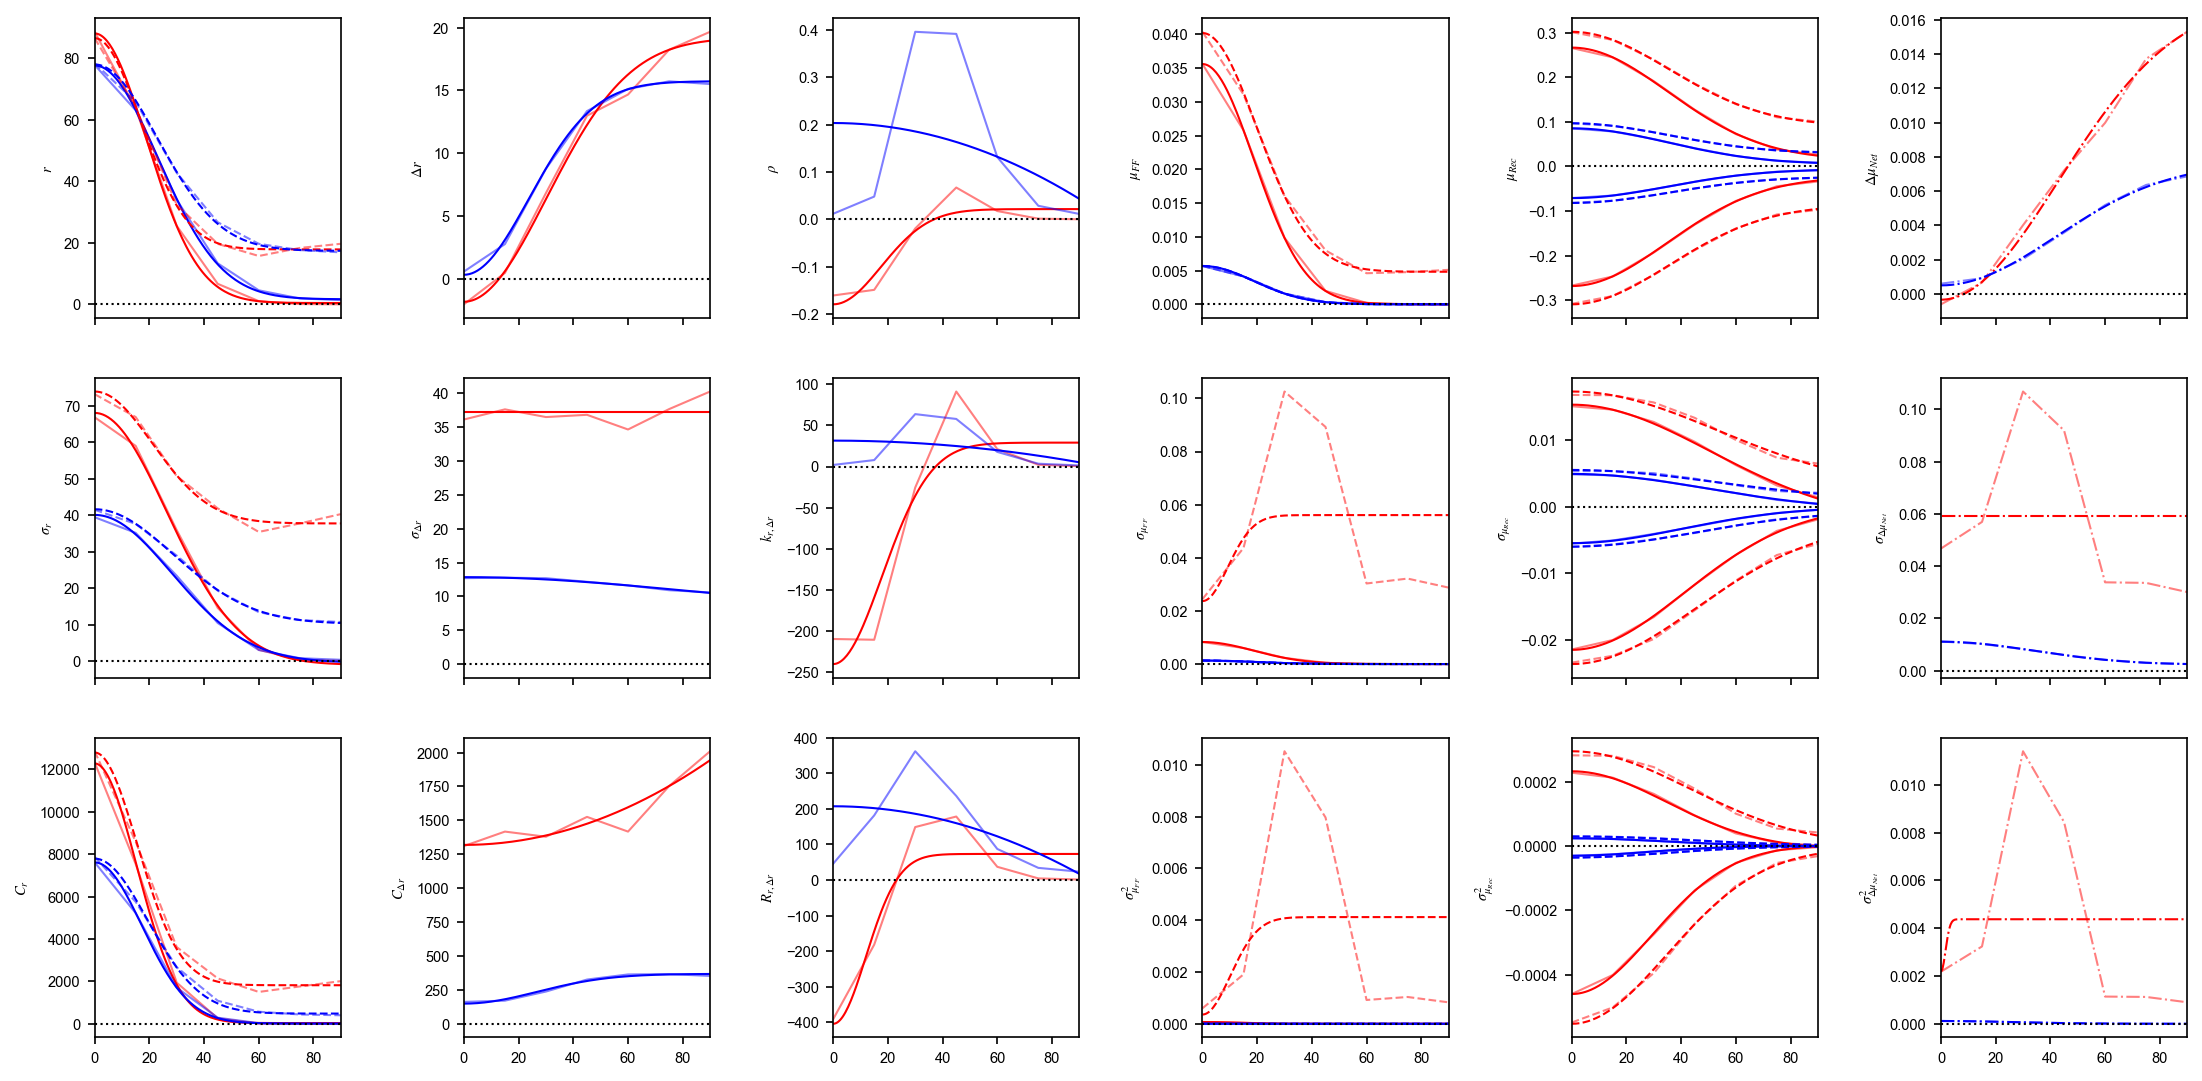

In [213]:
reload(pl)

fig,axs = plt.subplots(3,6,figsize=(18,9),dpi=150,sharex='all')
fig.subplots_adjust(hspace = .2, wspace=.5)
axs[0,0].set_xlim(0,90)

pl.plot_data_fit_line(axs[0,0],rate_ori_bounds,E_base_rate_per_ori_mean,'r_{b,E}','r','-')
pl.plot_data_fit_line(axs[0,0],rate_ori_bounds,I_base_rate_per_ori_mean,'r_{b,I}','b','-')
pl.plot_data_fit_line(axs[0,0],rate_ori_bounds,E_opto_rate_per_ori_mean,'r_{o,E}','r','--')
pl.plot_data_fit_line(axs[0,0],rate_ori_bounds,I_opto_rate_per_ori_mean,'r_{o,I}','b','--')
axs[0,0].axhline(0,c='k',ls=':')
axs[0,0].set_ylabel(r'$r$')

pl.plot_data_fit_line(axs[1,0],rate_ori_bounds,E_base_rate_per_ori_std,'σr_{b,E}','r','-')
pl.plot_data_fit_line(axs[1,0],rate_ori_bounds,I_base_rate_per_ori_std,'σr_{b,I}','b','-')
pl.plot_data_fit_line(axs[1,0],rate_ori_bounds,E_opto_rate_per_ori_std,'σr_{o,E}','r','--')
pl.plot_data_fit_line(axs[1,0],rate_ori_bounds,I_opto_rate_per_ori_std,'σr_{o,I}','b','--')
axs[1,0].axhline(0,c='k',ls=':')
axs[1,0].set_ylabel(r'$\sigma_r$')

pl.plot_data_fit_line(axs[2,0],rate_ori_bounds,E_base_rate_per_ori_std**2+\
                   E_base_rate_per_ori_mean**2,'Cr_{b,E}','r','-')
pl.plot_data_fit_line(axs[2,0],rate_ori_bounds,I_base_rate_per_ori_std**2+\
                   I_base_rate_per_ori_mean**2,'Cr_{b,I}','b','-')
pl.plot_data_fit_line(axs[2,0],rate_ori_bounds,E_opto_rate_per_ori_std**2+\
                   E_opto_rate_per_ori_mean**2,'Cr_{o,E}','r','--')
pl.plot_data_fit_line(axs[2,0],rate_ori_bounds,I_opto_rate_per_ori_std**2+\
                   I_opto_rate_per_ori_mean**2,'Cr_{o,I}','b','--')
axs[2,0].axhline(0,c='k',ls=':')
axs[2,0].set_ylabel(r'$C_r$')

pl.plot_data_fit_line(axs[0,1],rate_ori_bounds,E_diff_rate_per_ori_mean,'Δr_E','r','-')
pl.plot_data_fit_line(axs[0,1],rate_ori_bounds,I_diff_rate_per_ori_mean,'Δr_I','b','-')
axs[0,1].axhline(0,c='k',ls=':')
axs[0,1].set_ylabel(r'$\Delta r$')

pl.plot_data_fit_line(axs[1,1],rate_ori_bounds,E_diff_rate_per_ori_std,'σΔr_E','r','-')
pl.plot_data_fit_line(axs[1,1],rate_ori_bounds,I_diff_rate_per_ori_std,'σΔr_I','b','-')
axs[1,1].axhline(0,c='k',ls=':')
axs[1,1].set_ylabel(r'$\sigma_{\Delta r}$')

pl.plot_data_fit_line(axs[2,1],rate_ori_bounds,E_diff_rate_per_ori_std**2+\
                   E_diff_rate_per_ori_mean**2,'CΔr_E','r','-')
pl.plot_data_fit_line(axs[2,1],rate_ori_bounds,I_diff_rate_per_ori_std**2+\
                   I_diff_rate_per_ori_mean**2,'CΔr_I','b','-')
axs[2,1].axhline(0,c='k',ls=':')
axs[2,1].set_ylabel(r'$C_{\Delta r}$')

pl.plot_data_fit_line(axs[0,2],rate_ori_bounds,E_diff_rate_per_ori_cov/
                   E_diff_rate_per_ori_std**2,'σΔr_E','r','-')
pl.plot_data_fit_line(axs[0,2],rate_ori_bounds,I_diff_rate_per_ori_cov/
                   I_diff_rate_per_ori_std**2,'σΔr_I','b','-')
axs[0,2].axhline(0,c='k',ls=':')
axs[0,2].set_ylabel(r'$\rho$')

pl.plot_data_fit_line(axs[1,2],rate_ori_bounds,E_diff_rate_per_ori_cov,'σΔr_E','r','-')
pl.plot_data_fit_line(axs[1,2],rate_ori_bounds,I_diff_rate_per_ori_cov,'σΔr_I','b','-')
axs[1,2].axhline(0,c='k',ls=':')
axs[1,2].set_ylabel(r'$k_{r,\Delta r}$')

pl.plot_data_fit_line(axs[2,2],rate_ori_bounds,E_diff_rate_per_ori_cov+\
                   E_base_rate_per_ori_mean*\
                   E_diff_rate_per_ori_mean,'RrΔr_E','r','-')
pl.plot_data_fit_line(axs[2,2],rate_ori_bounds,I_diff_rate_per_ori_cov+\
                   I_base_rate_per_ori_mean*\
                   I_diff_rate_per_ori_mean,'RrΔr_I','b','-')
axs[2,2].axhline(0,c='k',ls=':')
axs[2,2].set_ylabel(r'$R_{r,\Delta r}$')

pl.plot_data_fit_line(axs[0,3],rate_ori_bounds,EF_base_input_per_ori_mean,'μ_{b,EF}','r','-')
pl.plot_data_fit_line(axs[0,3],rate_ori_bounds,IF_base_input_per_ori_mean,'μ_{b,IF}','b','-')
pl.plot_data_fit_line(axs[0,3],rate_ori_bounds,EF_opto_input_per_ori_mean,'μ_{o,EF}','r','--')
pl.plot_data_fit_line(axs[0,3],rate_ori_bounds,IF_opto_input_per_ori_mean,'μ_{o,IF}','b','--')
axs[0,3].axhline(0,c='k',ls=':')
axs[0,3].set_ylabel(r'$\mu_{FF}$')

pl.plot_data_fit_line(axs[1,3],rate_ori_bounds,EF_base_input_per_ori_std,'σμ_{b,EF}','r','-')
pl.plot_data_fit_line(axs[1,3],rate_ori_bounds,IF_base_input_per_ori_std,'σμ_{b,IF}','b','-')
pl.plot_data_fit_line(axs[1,3],rate_ori_bounds,EF_opto_input_per_ori_std,'σμ_{o,EF}','r','--')
pl.plot_data_fit_line(axs[1,3],rate_ori_bounds,IF_opto_input_per_ori_std,'σμ_{o,IF}','b','--')
axs[1,3].axhline(0,c='k',ls=':')
axs[1,3].set_ylabel(r'$\sigma_{\mu_{FF}}$')

pl.plot_data_fit_line(axs[2,3],rate_ori_bounds,EF_base_input_per_ori_std**2,'σμ2_{b,EF}','r','-')
pl.plot_data_fit_line(axs[2,3],rate_ori_bounds,IF_base_input_per_ori_std**2,'σμ2_{b,IF}','b','-')
pl.plot_data_fit_line(axs[2,3],rate_ori_bounds,EF_opto_input_per_ori_std**2,'σμ2_{o,EF}','r','--')
pl.plot_data_fit_line(axs[2,3],rate_ori_bounds,IF_opto_input_per_ori_std**2,'σμ2_{o,IF}','b','--')
axs[2,3].axhline(0,c='k',ls=':')
axs[2,3].set_ylabel(r'$\sigma^2_{\mu_{FF}}$')

pl.plot_data_fit_line(axs[0,4],rate_ori_bounds,EE_base_input_per_ori_mean,'μ_{b,EE}','r','-')
pl.plot_data_fit_line(axs[0,4],rate_ori_bounds,IE_base_input_per_ori_mean,'μ_{b,IE}','b','-')
pl.plot_data_fit_line(axs[0,4],rate_ori_bounds,EE_opto_input_per_ori_mean,'μ_{o,EE}','r','--')
pl.plot_data_fit_line(axs[0,4],rate_ori_bounds,IE_opto_input_per_ori_mean,'μ_{o,IE}','b','--')
pl.plot_data_fit_line(axs[0,4],rate_ori_bounds,EI_base_input_per_ori_mean,'μ_{b,EI}','r','-')
pl.plot_data_fit_line(axs[0,4],rate_ori_bounds,II_base_input_per_ori_mean,'μ_{b,II}','b','-')
pl.plot_data_fit_line(axs[0,4],rate_ori_bounds,EI_opto_input_per_ori_mean,'μ_{o,EI}','r','--')
pl.plot_data_fit_line(axs[0,4],rate_ori_bounds,II_opto_input_per_ori_mean,'μ_{o,II}','b','--')
axs[0,4].axhline(0,c='k',ls=':')
axs[0,4].set_ylabel(r'$\mu_{Rec}$')

pl.plot_data_fit_line(axs[1,4],rate_ori_bounds,EE_base_input_per_ori_std,'σμ_{b,EE}','r','-')
pl.plot_data_fit_line(axs[1,4],rate_ori_bounds,IE_base_input_per_ori_std,'σμ_{b,IE}','b','-')
pl.plot_data_fit_line(axs[1,4],rate_ori_bounds,EE_opto_input_per_ori_std,'σμ_{o,EE}','r','--')
pl.plot_data_fit_line(axs[1,4],rate_ori_bounds,IE_opto_input_per_ori_std,'σμ_{o,IE}','b','--')
pl.plot_data_fit_line(axs[1,4],rate_ori_bounds,-EI_base_input_per_ori_std,'σμ_{b,EI}','r','-')
pl.plot_data_fit_line(axs[1,4],rate_ori_bounds,-II_base_input_per_ori_std,'σμ_{b,II}','b','-')
pl.plot_data_fit_line(axs[1,4],rate_ori_bounds,-EI_opto_input_per_ori_std,'σμ_{o,EI}','r','--')
pl.plot_data_fit_line(axs[1,4],rate_ori_bounds,-II_opto_input_per_ori_std,'σμ_{o,II}','b','--')
axs[1,4].axhline(0,c='k',ls=':')
axs[1,4].set_ylabel(r'$\sigma_{\mu_{Rec}}$')

pl.plot_data_fit_line(axs[2,4],rate_ori_bounds,EE_base_input_per_ori_std**2,'σμ2_{b,EE}','r','-')
pl.plot_data_fit_line(axs[2,4],rate_ori_bounds,IE_base_input_per_ori_std**2,'σμ2_{b,IE}','b','-')
pl.plot_data_fit_line(axs[2,4],rate_ori_bounds,EE_opto_input_per_ori_std**2,'σμ2_{o,EE}','r','--')
pl.plot_data_fit_line(axs[2,4],rate_ori_bounds,IE_opto_input_per_ori_std**2,'σμ2_{o,IE}','b','--')
pl.plot_data_fit_line(axs[2,4],rate_ori_bounds,-EI_base_input_per_ori_std**2,'σμ2_{b,EI}','r','-')
pl.plot_data_fit_line(axs[2,4],rate_ori_bounds,-II_base_input_per_ori_std**2,'σμ2_{b,II}','b','-')
pl.plot_data_fit_line(axs[2,4],rate_ori_bounds,-EI_opto_input_per_ori_std**2,'σμ2_{o,EI}','r','--')
pl.plot_data_fit_line(axs[2,4],rate_ori_bounds,-II_opto_input_per_ori_std**2,'σμ2_{o,II}','b','--')
axs[2,4].axhline(0,c='k',ls=':')
axs[2,4].set_ylabel(r'$\sigma^2_{\mu_{Rec}}$')

pl.plot_data_fit_line(axs[0,5],rate_ori_bounds,ET_opto_input_per_ori_mean-\
              ET_base_input_per_ori_mean,'Δμ_{E}','r','-.')
pl.plot_data_fit_line(axs[0,5],rate_ori_bounds,IT_opto_input_per_ori_mean-\
              IT_base_input_per_ori_mean,'Δμ_{E}','b','-.')
axs[0,5].axhline(0,c='k',ls=':')
axs[0,5].set_ylabel(r'$\Delta\mu_{Net}$')

pl.plot_data_fit_line(axs[1,5],rate_ori_bounds,np.sqrt(ET_opto_input_per_ori_std**2+\
              ET_base_input_per_ori_std**2),'σΔμ_{E}','r','-.')
pl.plot_data_fit_line(axs[1,5],rate_ori_bounds,np.sqrt(IT_opto_input_per_ori_std**2+\
              IT_base_input_per_ori_std**2),'σΔμ_{E}','b','-.')
axs[1,5].axhline(0,c='k',ls=':')
axs[1,5].set_ylabel(r'$\sigma_{\Delta\mu_{Net}}$')

pl.plot_data_fit_line(axs[2,5],rate_ori_bounds,ET_opto_input_per_ori_std**2+\
              ET_base_input_per_ori_std**2,'σΔμ2_{E}','r','-.')
pl.plot_data_fit_line(axs[2,5],rate_ori_bounds,IT_opto_input_per_ori_std**2+\
              IT_base_input_per_ori_std**2,'σΔμ2_{E}','b','-.')
axs[2,5].axhline(0,c='k',ls=':')
axs[2,5].set_ylabel(r'$\sigma^2_{\Delta\mu_{Net}}$')